# Texture segmentation

This assignment covers simple texture segmentation using either Histogram model matching, point model distances, etc.

The purpose is to some segment regions (wall, sky, roof, pathway) from this photography, using texture segmentation techniques:

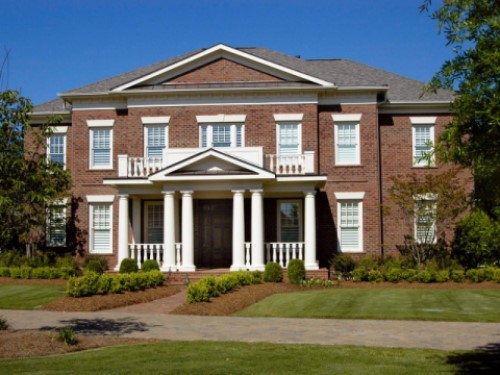

This assignment uses opencv (3+) and matplotlib.


Ideal expected results should be like this:
 

# Setup



In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

root_ds = '.'

## Mounting Google Drive (Google Colab only)
First, we'll mount the distant Google Drive locally. We assume here you have created a shortcut `2020-MSAIMove_computervision_shared` pointing to the class shared folder.

Rather than downloading, distant mounting ensure fast access without need of download.

In [19]:
if 'google.colab' in str(get_ipython()):
  import os
  from google.colab import drive
  drive.mount('/content/drive')

#  root_ds = '/content/drive/MyDrive/2021-MSAIMove_computervision_shared/datasets/'
  root_ds = '/content/drive/MyDrive/Colab Notebooks/datasets'

  assert(os.path.exists(root_ds))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exercise

First, let's load the image (in BGR format), and compute its HSV encoding (Hue Saturation Value).

In [20]:
imBGR = cv2.imread(os.path.join(root_ds, "../datasets/misc/house.jpg"))
# Convert to BGR to HSV
imHSV = cv2.cvtColor(imBGR, cv2.COLOR_BGR2HSV)

assert(imBGR is not None)

Let's plot the image. Remember we first need to reverse the color axis because Matplotlib uses RGB while OpenCV uses BGR. It is done with `array[..., ::-1]` where the `...` means *all axis until* and `::-1` means reverse order.

Text(0.5, 1.0, 'HSV')

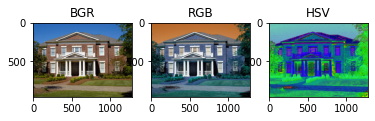

In [21]:
# BGR => RGB in order to display it correctly with matplotlib
plt.figure(1)

plt.subplot(131)
plt.imshow(imBGR[..., ::-1])
plt.title('BGR')

plt.subplot(132)
plt.imshow(imBGR)
plt.title('RGB')

plt.subplot(133)
plt.imshow(imHSV)
plt.title('HSV')

# # Accessing a pixel (y, x) in the image
#print(imBGR[1, 15])

# # Slice a part of the image, e.g. [y1:y2, x1:x2]
#plt.figure(2)
#print(imBGR[10:50, 100:110].shape)
#plt.imshow(imBGR[10:50, 100:110][..., ::-1])

# # Compute the average color of the sky patch
#sky_patch = imBGR[10:50, 100:110]
#print(sky_patch.shape)
#print(sky_patch.mean(axis=(0,1)))

## Texture segmentation
**Let's try to segment the wall bricks.**

Here, you need to select a sub part of the image with `imHSV[y1:y2, x1:x2]` and compute its histogram. Computing the histogram is achieved with the `cv2.calcHist(image, channels, mask, sizes, ranges)`.
Where, `image` is the image on which to compute the histogram, `channels` is a list of channel index to compute the histogram on, `mask` of the image parameter generally set to None to compute the full image histogram, `sizes` a list of number of bins channel-wise, `ranges` a list of paired \[min,max\] values for the histogram.

Once the histogram is computed, you may compute the backprojection of the later on an image with `cv2.calcBackProject(image, channels, hist, ranges, scale)` where `channels` and `ranges` are similar as before, `image` is the image on which to apply backprojection, `scale` is a scaling factor of the function output (typically, 255).

' Note: At the end of the back projection, the objects obtained are images of the same size in terms of \n    number of pixels as the original image except that they have lost 2 dimensions relative to the colors.'

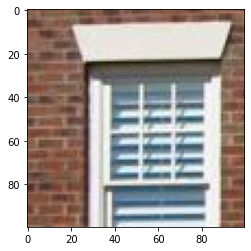

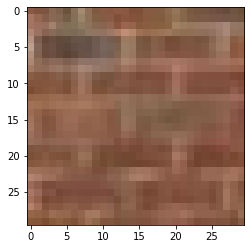

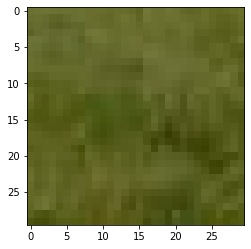

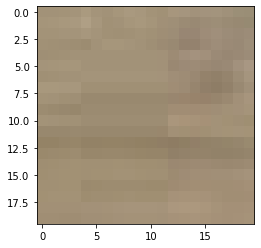

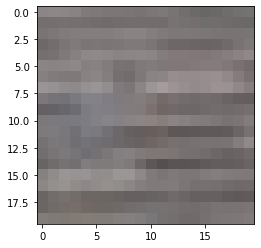

In [48]:
# Select Patches (sub part of the image):
patch = imHSV[300:400, 200:300]   #initial patch
patch2 = imHSV[380:410,980:1010]  #brick_wall
patch3 = imHSV[900:930,600:630]   #grass
patch4 = imHSV[820:840,820:840]   #path way
patch5 = imHSV[200:220,900:920]  #roof
  #...sky

# Show Patches
plt.figure(1) #initial patch
plt.imshow(cv2.cvtColor(patch, cv2.COLOR_HSV2BGR)[..., ::-1])
plt.figure(2) #brick_wall
plt.imshow(cv2.cvtColor(patch2, cv2.COLOR_HSV2BGR)[..., ::-1])
plt.figure(3) #grass
plt.imshow(cv2.cvtColor(patch3, cv2.COLOR_HSV2BGR)[..., ::-1])
plt.figure(4) #path way
plt.imshow(cv2.cvtColor(patch4, cv2.COLOR_HSV2BGR)[..., ::-1])
plt.figure(5) #roof
plt.imshow(cv2.cvtColor(patch5, cv2.COLOR_HSV2BGR)[..., ::-1])

# Build histograms (HSV):
channels = [0, 1] # channels you want to build the histogram on (0=Hue, 1=Saturation, 2=Value)
sizes = [256, 256] # size per-channel
ranges = [0, 255, 0, 255] # ranges of values per-channel (min_channel_0, max_channel_0, min_channel_1, max_channel_1, ...)

hist = cv2.calcHist([patch], channels, None, sizes, ranges)    #initial patch
hist2 = cv2.calcHist([patch2], channels, None, sizes, ranges)  #brick_wall channels [0,1] (Hue and Saturation)
hist2bis = cv2.calcHist([patch2], [0], None, [256], [0, 255])  #brick_wall channel [0] (Hue)
hist2bis2 = cv2.calcHist([patch2], [1], None, [256], [0, 255]) #brick_wall channel [1] (Saturation)
hist3 = cv2.calcHist([patch3], channels, None, sizes, ranges)  #grass
hist4 = cv2.calcHist([patch4], channels, None, sizes, ranges)  #path way
hist5 = cv2.calcHist([patch5], channels, None, sizes, ranges)  #roof

""" Note: Concerning the brick wall I tried to underline the influence of the choice of the Hue and Saturation 
          channels on the efficiency of the model. That's why I created histograms hist2bis and hist2bis2."""

# Normalize histograms 

cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
cv2.normalize(hist2, hist2, 0, 255, cv2.NORM_MINMAX)
cv2.normalize(hist3, hist3, 0, 255, cv2.NORM_MINMAX)
cv2.normalize(hist4, hist4, 0, 255, cv2.NORM_MINMAX)
cv2.normalize(hist5, hist5, 0, 255, cv2.NORM_MINMAX)


# Compute the histogram back projection:
lhMap = cv2.calcBackProject([imHSV], channels, hist, ranges, 255)           #initial patch
lhMap2 = cv2.calcBackProject([imHSV], channels, hist2, ranges, 255)         #brick_wall channels [0,1] (Hue and Saturation
lhMap2bis = cv2.calcBackProject([imHSV], channels, hist2bis, ranges, 255)   #brick_wall channel [0] (Hue)
lhMap2bis2 = cv2.calcBackProject([imHSV], channels, hist2bis2, ranges, 255) #brick_wall channel [1] (Saturation)
lhMap3 = cv2.calcBackProject([imHSV], channels, hist3, ranges, 255)         #grass
lhMap4 = cv2.calcBackProject([imHSV], channels, hist4, ranges, 255)         #path way
lhMap5 = cv2.calcBackProject([imHSV], channels, hist5, ranges, 255)         #roof

""" Note: At the end of the back projection, the objects obtained are images of the same size in terms of 
    number of pixels as the original image except that they have lost 2 dimensions relative to the colors.""" 



Now we plot the likelihood map of the brick for the current texture segmentation.

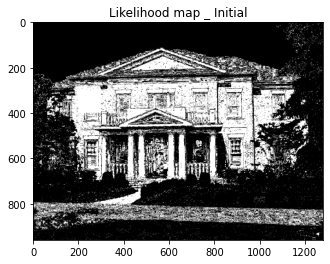

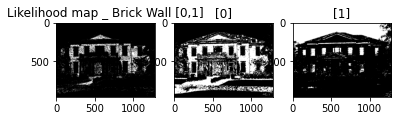

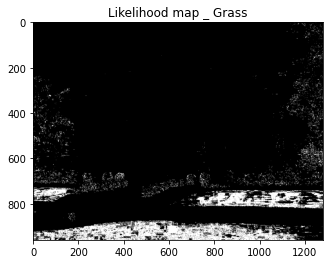

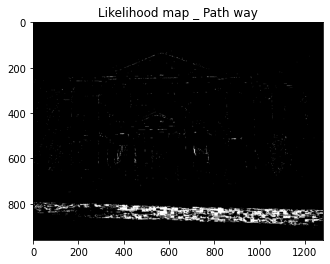

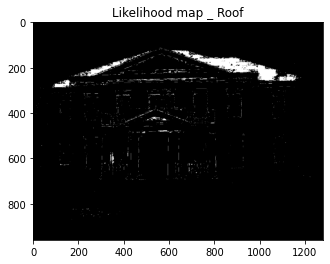

In [49]:
# Don't forget to plot a BGR image
plt.figure(1) #initial patch
plt.imshow(lhMap/lhMap.max(), cmap="gray")
plt.title('Likelihood map _ Initial')


plt.figure(2) #brick_wall
plt.subplot(131)
plt.imshow(lhMap2/lhMap2.max(), cmap="gray")
plt.title('Likelihood map _ Brick Wall [0,1]')
plt.subplot(132)
plt.imshow(lhMap2bis/lhMap2bis.max(), cmap="gray")
plt.title('[0]')
plt.subplot(133)
plt.imshow(lhMap2bis2/lhMap2bis2.max(), cmap="gray")
plt.title('[1]')

"""Note: We can see that taking 2 dimensions (Hue and Saturation), allows to have a more accurate 
         result than only taking one or the other, in this case."""

plt.figure(3) #grass
plt.imshow(lhMap3/lhMap3.max(), cmap="gray")
plt.title('Likelihood map _ Grass')

plt.figure(4) #path way
plt.imshow(lhMap4/lhMap4.max(), cmap="gray")
plt.title('Likelihood map _ Path way')

plt.figure(5) #roof
plt.imshow(lhMap5/lhMap5.max(), cmap="gray")
plt.title('Likelihood map _ Roof')

plt.show()



If you managed to correctly segment the wall bricks, now proceed with *pathway*.
Once done, segment the *sky*. Can you think of a better way to segment the sky ? Try doing it.

## Colored segmentation display

After having segmented few textures in the images, try combining all the likelihood map to output the colored segmentation image.

'Note: we observe that the "Cmap" does not highlight well the different elements of the image'

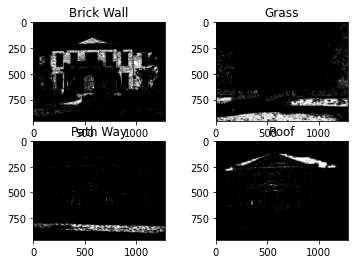

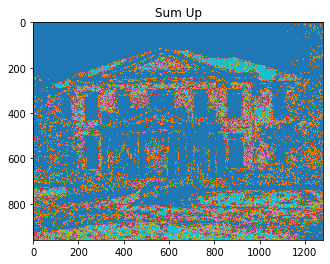

In [50]:
##Seuillage Automatique _ Méthode Otsu
# Opération qui transforme une image en niveau de gris en une image binaire (noir, blanc). 
# L'image optenue est appelée masque binaire
ret2,th2 = cv2.threshold(lhMap2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #brick wall
ret3,th3 = cv2.threshold(lhMap3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #grass
ret4,th4 = cv2.threshold(lhMap4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #path way
ret5,th5 = cv2.threshold(lhMap5,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #roof

# Superposition of the differents masks
th=cv2.bitwise_or(th2, th3)
th=cv2.bitwise_or(th, th4)
th=cv2.bitwise_or(th, th5)

plt.figure(2)
plt.subplot(221)
plt.imshow(th2, cmap="gray")
plt.title('Brick Wall')
plt.subplot(222)
plt.imshow(th3, cmap="gray")
plt.title('Grass')
plt.subplot(223)
plt.imshow(th4, cmap="gray")
plt.title('Path Way')
plt.subplot(224)
plt.imshow(th5, cmap="gray")
plt.title('Roof')


plt.figure(6)
plt.imshow(th, cmap="tab10")
plt.title('Sum Up')

"""Note: we observe that the "Cmap" does not highlight well the different elements of the image.
         In fact, the roof, the wall, the grass and the path are displayed in the same way """


# Test 1 : Affichage avec Seuillage


L'image crée à l'issus du seuillage sur Hue a pour dimensions: (960, 1280)
L'image imHSV est de dimensions: (960, 1280, 3)
Le patch2 est de dimensions: (30, 30, 3)
L'histogramme du patch (HSV) est de dimensions:  (256, 256)
L'image obtenue à l'issue de la back projection du patch 2 est de dimensions:  (960, 1280)
th2 obtenue après seuillage est de dimension en HSV: (960, 1280)
Img 2 obtenue après enregistrement du seuillage est de dimension en RGB: (960, 1280, 3)


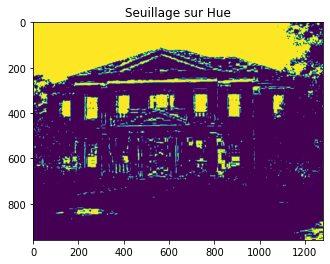

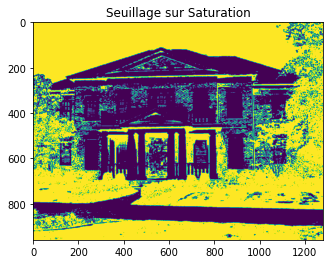

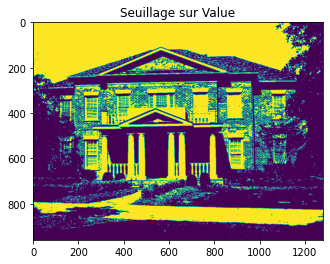

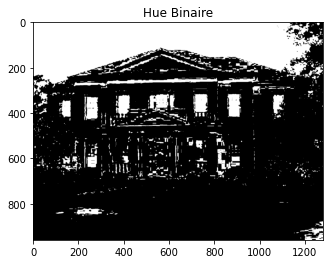

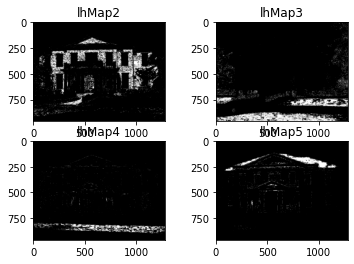

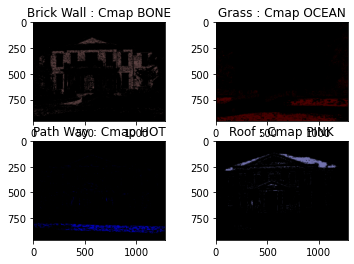

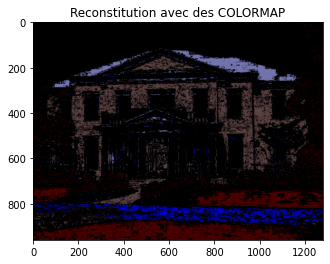

In [51]:
# Test 1
"""L'idée ici était de séparer les zones rechercher sur chaque image du reste afin d'en faire des images
binaire (Noir/Blanc) et d'ensuite leur appliquer une unique couleur à chacune avant des les rassembler en 
une seule et même image où chaque zone aurait sa propre couleur"""

# Division de l'image imHSV selon ses 3 dimensions
h, s, v= cv2.split(imHSV)
ret_h, th_h = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_s, th_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_v, th_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Affichage des différents seuillage
plt.figure(1)
plt.imshow(th_h)
plt.title("Seuillage sur Hue")

plt.figure(2)
plt.imshow(th_s)
plt.title("Seuillage sur Saturation")

plt.figure(3)
plt.imshow(th_v)
plt.title("Seuillage sur Value")

# Visualisation en Binaire du seuillage réalisé sur imHSV (Black & White)
cv2.imwrite("th_h.png", th_h) #Enregistrement du seuillage de la dimension Hue
print("L'image crée à l'issus du seuillage sur Hue a pour dimensions:",th_h.shape)

   # Lecture et affichage de Hue en binaire 
plt.figure(4)
img = cv2.imread("th_h.png") 
plt.imshow(img)
plt.title("Hue Binaire")



# Enregistrement des images binaires en format PNG
cv2.imwrite("th2.png", th2)
cv2.imwrite("th3.png", th3)
cv2.imwrite("th4.png", th4)
cv2.imwrite("th5.png", th5)

# Lecture des images enregistrées 
img2 = cv2.imread("th2.png") 
img3 = cv2.imread("th3.png")
img4 = cv2.imread("th4.png")
img5 = cv2.imread("th5.png")

# Visulation en Binaire du seuillage réalisé sur lhMap2, lhMap3, lhMap3, lhMap4
plt.figure(5)
plt.subplot(221)
plt.imshow(img2)
plt.title('lhMap2')
plt.subplot(222)
plt.imshow(img3)
plt.title('lhMap3')
plt.subplot(223)
plt.imshow(img4)
plt.title('lhMap4')
plt.subplot(224)
plt.imshow(img5)
plt.title('lhMap5')

#Conversion des images enregistrées en HSV puis application de COLORMAP 
# liste des Cmap: https://learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
img2 = cv2.applyColorMap(img2, cv2.COLORMAP_BONE)
img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2HSV)
img3 = cv2.applyColorMap(img3, cv2.COLORMAP_OCEAN)
img4 = cv2.cvtColor(img4, cv2.COLOR_RGB2HSV)
img4 = cv2.applyColorMap(img4, cv2.COLORMAP_HOT)
img5 = cv2.cvtColor(img5, cv2.COLOR_RGB2HSV)
img5 = cv2.applyColorMap(img5, cv2.COLORMAP_PINK)

# Reconstitution des différents éléments en une seule image
IMG = img2 + img3 + img4 + img5

# Affichage des images auxquelles ont été appliqués les COLORMAP 
plt.figure(6)
plt.subplot(221)
plt.title('Brick Wall : Cmap BONE')
plt.imshow(img2)
plt.subplot(222)
plt.title('Grass : Cmap OCEAN')
plt.imshow(img3)
plt.subplot(223)
plt.title('Path Way : Cmap HOT')
plt.imshow(img4)
plt.subplot(224)
plt.imshow(img5)
plt.title('Roof : Cmap PINK')

# Affichage de l'image reconstituée IMG
plt.figure(7)
plt.imshow(IMG)
plt.title('Reconstitution avec des COLORMAP')



#_Comparaison des dimensions des différents compotants______________________________________________#
print("L'image imHSV est de dimensions:", imHSV.shape)
print("Le patch2 est de dimensions:", patch2.shape)
print("L'histogramme du patch (HSV) est de dimensions: ", hist2.shape)
print("L'image obtenue à l'issue de la back projection du patch 2 est de dimensions: ", lhMap2.shape)
print("th2 obtenue après seuillage est de dimension en HSV:",th2.shape)
print("Img 2 obtenue après enregistrement du seuillage est de dimension en RGB:",img2.shape)

#Test 2: Tentative de création de Color Map pour améliorer le rendu (Échec)

In [ ]:
#Test 2: Création color map
"""L'idée ici était de créer un color map avec des couleurs unies pour améliorer
le rendu obtenu dans la section précédente Test 1"""

"""
lut = np.zeros((256, 1, 3), dtype=np.uint8)
#Red
lut[:, 0, 0] = lut[0,255,0,255] #Vert, jaune, bleu, rouge
#Green
lut[:, 0, 1] = [255,255,0,0]
#Blue
lut[:, 0, 2] = [0,0,255,0]

#Apply custom colormap through LUT
 = cv2.LUT(lhMap2, lut)

lhMap6 = cv2.applyColorMap(lhMap6, cv2.COLORMAP_JET)
plt.figure(6)
plt.imshow(lhMap6/lhMap6.max())
"""


# Test 3 : Affichage des couleurs dans chaque Color Space

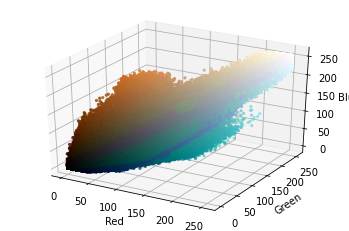

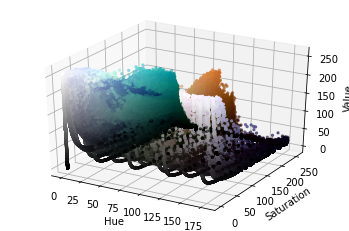

In [ ]:
#Test 3 : Affichage couleurs
""" L'idée ici consiste à représenter la distribution des couleurs des images de la maison en BGR et en HSV de
manière à pouvoir établir des limites applicables pour la création de masks  """

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

# Division des 3 dimensions de la maison en BGR
r, g, b = cv2.split(imBGR[..., ::-1])
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# Normalisation
pixel_colors = imBGR.reshape((np.shape(imBGR[..., ::-1])[0]*np.shape(imBGR[..., ::-1])[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

# Affichage de la distribution des couleurs selon les 3 axes
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()



# Division des 3 dimensions de la maison en HSV
h, s, v = cv2.split(imHSV)
fig2 = plt.figure()
axis = fig2.add_subplot(1, 1, 1, projection="3d")

# Affichage de la distribution des couleurs selon les 3 axes
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()
